# Stock Price machine Learning

-----------------------------------
## Historical Data Pull for Amazon

In [2]:
import pandas as pd
from alpaca_trade_api.rest import REST, TimeFrame
from fredapi import Fred
import yfinance as yf
import datetime
import pandas_ta as ta

# Keys
ALPACA_API_KEY = ''
ALPACA_API_SECRET = ''
BASE_URL = 'https://api.alpaca.markets'
FRED_API_KEY = ''
STOCK_SYMBOL = 'AMZN'
ADDITIONAL_SYMBOLS = ['AAPL', 'MSFT', 'GOOGL', 'META', 'WMT', 'BABA']

# Initialize the Alpaca and FRED API
api = REST(ALPACA_API_KEY, ALPACA_API_SECRET, BASE_URL)
fred = Fred(api_key=FRED_API_KEY)

# Function to fetch minute-level stock data from Alpaca
def fetch_minute_stock_data(ticker, start_date, end_date):
    all_data = pd.DataFrame()
    while start_date < end_date:
        chunk_end_date = start_date + datetime.timedelta(days=30)
        if chunk_end_date > end_date:
            chunk_end_date = end_date
        print(f'Fetching data from {start_date.strftime("%Y-%m-%d")} to {chunk_end_date.strftime("%Y-%m-%d")}')
        
        data = api.get_bars(
            ticker, 
            TimeFrame.Minute, 
            start=start_date.strftime('%Y-%m-%d'), 
            end=chunk_end_date.strftime('%Y-%m-%d'), 
            adjustment='raw',
            limit= None,
            feed='iex'
        ).df

        all_data = pd.concat([all_data, data])
        start_date = chunk_end_date

    all_data.index = pd.to_datetime(all_data.index)
    return all_data

# Fetch minute-level stock data for the main symbol
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=365)
merged_df = fetch_minute_stock_data(STOCK_SYMBOL, start_date, end_date)

ValueError: ('Key ID must be given to access Alpaca trade API', ' (env: APCA_API_KEY_ID)')

In [6]:
df=merged_df
df.shape

(98687, 7)

-----------------------------------
### Adjusted Close Plot for Visual

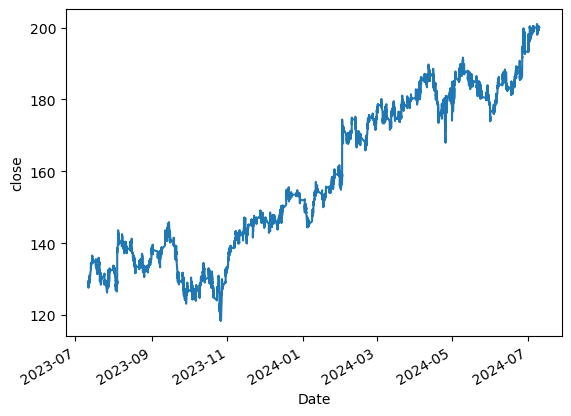

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

df['close'].plot()
plt.xlabel('Date')
plt.ylabel('close')
plt.show()

-----------------------------------
## Technical Indicator Calculations

In [ ]:
df.ta.indicators()

In [7]:
# Calculate Moving Averages
df.ta.sma(length=10, append=True)
df.ta.sma(length=2, append=True)
df.ta.sma(length=5, append=True)
df.ta.sma(length=7, append=True)
df.ta.sma(length=14, append=True)
df.ta.sma(length=30, append=True)
df.ta.sma(length=50, append=True)
df.ta.sma(length=200, append=True)

# Calculate Bollinger Bands
df.ta.bbands(length=20, append=True) #volatility

# Calculate RSI
df.ta.rsi(length=14, append=True)

# Calculate MACD 
df.ta.macd(fast=12, slow=26, append=True)

print(df)

                             close     high      low  trade_count     open  \
timestamp                                                                    
2023-07-11 13:30:00+00:00  127.695  128.015  127.580           88  127.715   
2023-07-11 13:31:00+00:00  127.630  127.630  127.440           54  127.600   
2023-07-11 13:32:00+00:00  127.595  127.720  127.485           74  127.650   
2023-07-11 13:33:00+00:00  127.700  127.720  127.570           70  127.620   
2023-07-11 13:34:00+00:00  128.080  128.150  127.700           36  127.700   
...                            ...      ...      ...          ...      ...   
2024-07-09 19:56:00+00:00  199.400  199.410  199.290           48  199.310   
2024-07-09 19:57:00+00:00  199.410  199.430  199.335           40  199.335   
2024-07-09 19:58:00+00:00  199.405  199.450  199.400           77  199.445   
2024-07-09 19:59:00+00:00  199.340  199.440  199.310           96  199.365   
2024-07-10 12:31:00+00:00  199.980  199.980  199.980            

### Good Data Pull so far with calculations 
More Technical Indicators can be added as we go. Now for some plotting to get some visuals of what the data looks like.

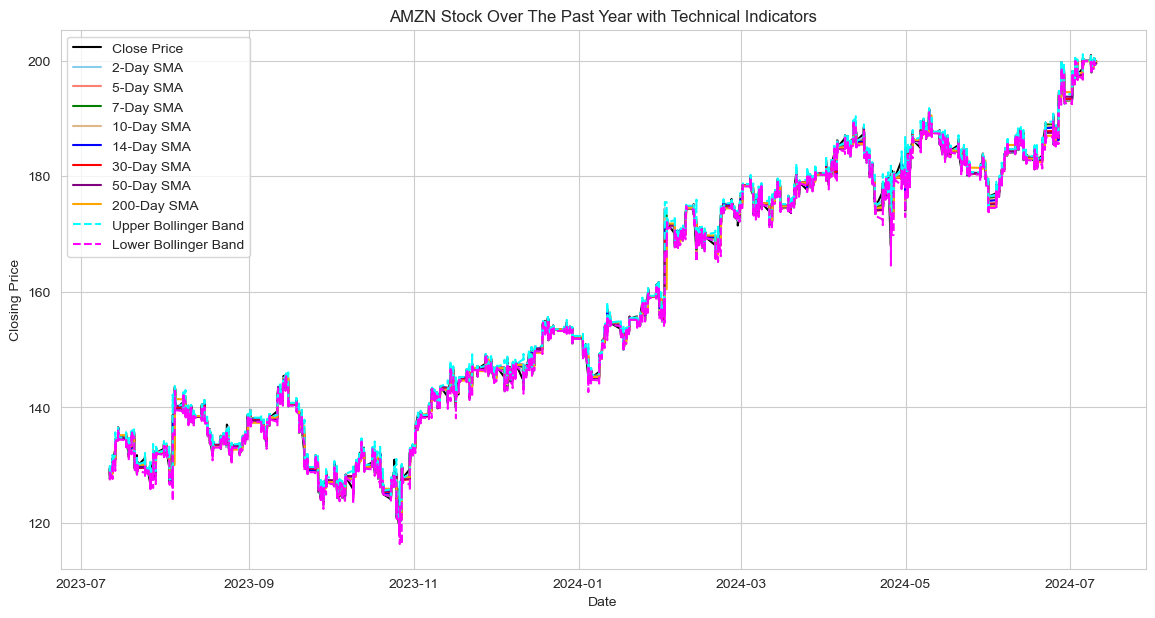

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.figure(figsize =(14,7))
# Moving Aveerages
plt.plot(df.index, df['close'], label = 'Close Price', color = 'black')
plt.plot(df.index,df['SMA_2'],label = '2-Day SMA', color = 'skyblue')
plt.plot(df.index,df['SMA_5'],label = '5-Day SMA', color = 'salmon')
plt.plot(df.index,df['SMA_7'],label = '7-Day SMA', color = 'green')
plt.plot(df.index,df['SMA_10'],label = '10-Day SMA', color = 'burlywood')
plt.plot(df.index, df['SMA_14'],label = '14-Day SMA',color = 'blue')
plt.plot(df.index, df['SMA_30'],label = '30-Day SMA', color = 'red')
plt.plot(df.index,df['SMA_50'], label = '50-Day SMA',color = 'purple')
plt.plot(df.index, df['SMA_200'], label = '200-Day SMA',color = 'orange')
# Bollinger Bands
plt.plot(df.index,df['BBU_20_2.0'],label = 'Upper Bollinger Band',color = 'cyan',linestyle = '--')
plt.plot(df.index,df['BBL_20_2.0'],label = 'Lower Bollinger Band',color = 'magenta',linestyle = '--')

plt.title('AMZN Stock Over The Past Year with Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

### Adding some more technical indicators

Pandas ta package not working synergistically with inputted close column for the dataframe.
Custom function below drawn from pandas_ta fixes the issue. 

#### Adding in the indicators

In [ ]:
# Full technical indicators minus other previous additions
df.ta.aberration(append=True)     # Aberration: Measures volatility
df.ta.above(above_value=160, append=True)  # Check if value is above 100
df.ta.accbands(append=True)      # Accumulation/Distribution Bands: Measure volatility
df.ta.ad(append=True)            # Accumulation/Distribution: Volume indicator
df.ta.adosc(append=True)         # Accumulation/Distribution Oscillator: Volume indicator
df.ta.adx(append=True)           # Average Directional Index: Measures trend strength
df.ta.alma(append=True)          # Arnaud Legoux Moving Average: Smoothed price data
df.ta.amat(append=True)          # Adaptative Moving Average Trend: Identifies trends
df.ta.ao(append=True)            # Awesome Oscillator: Measures momentum
df.ta.aobv(append=True)          # Above On Balance Volume: Volume indicator
df.ta.apo(append=True)           # Absolute Price Oscillator: Measures momentum
df.ta.aroon(append=True)         # Aroon: Identifies trend changes
df.ta.atr(append=True)           # Average True Range: Measures volatility
df.ta.below(below_value=50, append=True)  # Check if value is below 50
df.ta.bias(append=True)          # Bias: Measures deviation from a specified average
df.ta.bop(append=True)           # Balance of Power: Momentum indicator
df.ta.brar(append=True)          # (Bullish/Bearish) Rectangular Area: Momentum indicator
df.ta.cci(append=True)           # Commodity Channel Index: Identifies overbought/oversold conditions
df.ta.cfo(append=True)           # Chande Forecast Oscillator: Momentum indicator
df.ta.cg(append=True)            # Center of Gravity: Identifies turning points
df.ta.cmo(append=True)           # Chande Momentum Oscillator: Measures momentum
df.ta.coppock(append=True)       # Coppock Curve: Long-term momentum indicator
df.ta.cti(append=True)           # Closing Tick Indicator: Momentum indicator
df.ta.dm(append=True)           # Directional Movement: Measures trend direction
df.ta.er(append=True)           # Efficiency Ratio: Measures trend strength
df.ta.eri(append=True)          # Elder Ray Index: Combines bull and bear power
df.ta.fisher(append=True)       # Fisher Transform: Converts prices into a Gaussian normal distribution
df.ta.inertia(append=True)      # Inertia: Measures rate of change and direction
df.ta.kdj(append=True)          # Stochastic Oscillator: Measures momentum
df.ta.kst(append=True)          # Know Sure Thing (KST): Smoothed rate of change
df.ta.mom(append=True)          # Momentum: Measures rate of change in prices
df.ta.pgo(append=True)          # Percentage Price Oscillator: Measures momentum
df.ta.ppo(append=True)          # Price Percentage Oscillator: Measures momentum
df.ta.psl(append=True)          # Polarized Fractal Efficiency: Detects trends
df.ta.pvo(append=True)          # Percentage Volume Oscillator: Measures volume momentum
df.ta.qqe(append=True)          # Quantitative Qualitative Estimation: Identifies trends
df.ta.roc(append=True)          # Rate of Change: Measures momentum
df.ta.rsx(append=True)          # Relative Strength Index Smoothed: Smoothed RSI
df.ta.rvgi(append=True)          # Relative Vigor Index (RVI): Measures momentum
df.ta.slope(append=True)         # Slope: Measures the rate of change of a series
df.ta.smi(append=True)           # Stochastic Momentum Index (SMI): Measures momentum
df.ta.squeeze(append=True)       # Squeeze Momentum Indicator: Detects periods of low volatility
df.ta.squeeze_pro(append=True)   # Squeeze Pro: Enhanced version of Squeeze Momentum Indicator
df.ta.stc(append=True)           # Schaff Trend Cycle Indicator: Identifies market trends      
df.ta.stochrsi(append=True)      # Stochastic RSI: Combination of Stochastic Oscillator and RSI
df.ta.td_seq(append=True)        # TD Sequential: Detects trend exhaustion
df.ta.trix(append=True)          # Triple Exponential Average: Smoothed moving average
df.ta.tsi(append=True)           # True Strength Index: Measures trend direction
df.ta.uo(append=True)            # Ultimate Oscillator: Measures buying and selling pressure
df.ta.willr(append=True)        # Williams %R: Identifies overbought or oversold conditions
df.ta.dema(append=True)         # Double Exponential Moving Average (DEMA): Smoother average with emphasis on recent prices
df.ta.ema(append=True)          # Exponential Moving Average (EMA): Responsive to recent price changes
df.ta.fwma(append=True)         # Fixed Weighted Moving Average (FWMA): Evenly weighted moving average
df.ta.hilo(append=True)         # Highest High and Lowest Low (HILO): Identifies highest high and lowest low
df.ta.hl2(append=True)          # High-Low Midpoint (HL2): Midpoint between high and low prices
df.ta.hlc3(append=True)         # High-Low-Close Average (HLC3): Average of high, low, and close prices
df.ta.hma(append=True)          # Hull Moving Average (HMA): Reduced lag moving average
df.ta.hwma(append=True)         # Heikin Ashi Weighted Moving Average (HWMA): Smoothed moving average using Heikin Ashi candles
df.ta.ichimoku(append=True)     # Ichimoku Cloud: Trend-following indicator showing support, resistance, momentum, and trend direction
df.ta.jma(append=True)          # Jurik Moving Average (JMA): Dynamically smoothed moving average
df.ta.kama(append=True)         # Kaufman Adaptive Moving Average (KAMA): Adjusts sensitivity to market volatility
df.ta.linreg(append=True)       # Linear Regression: Fits a linear regression line to price data
df.ta.midpoint(append=True)     # Midpoint Price: Calculates the midpoint of high and low prices
df.ta.ohlc4(append=True)        # OHLC4 Average: Calculates the average of open, high, low, and close prices
df.ta.pwma(append=True)         # Volume Weighted Moving Average (PWMA): Moving average weighted by volume
df.ta.sinwma(append=True)       # Sine Weighted Moving Average (SINWMA): Moving average with sine weighting
df.ta.ssf(append=True)          # Sine Smoothed Filter (SSF): Smoothed version of the sine wave
df.ta.supertrend(append=True)   # Supertrend: Trend following indicator based on volatility
df.ta.t3(append=True)           # T3 Moving Average: Adaptive moving average
df.ta.tema(append=True)         # Triple Exponential Moving Average (TEMA): Smoother and more responsive moving average
df.ta.trima(append=True)        # Triangular Moving Average (TRIMA): Smoother moving average
df.ta.vidya(append=True)        # VIDYA (Variable Index Dynamic Average): Adjusts average based on market volatility
df.ta.vwap(append=True)         # Volume Weighted Average Price (VWAP): Average price weighted by volume
df.ta.vwma(append=True)         # Volume Weighted Moving Average (VWMA): Moving average weighted by volume
df.ta.wcp(append=True)          # Weighted Close Price (WCP): Weighted average of high, low, and close prices
df.ta.zlma(append=True)         # Zero Lag Moving Average (ZLMA): Moving average with reduced lag
df.ta.log_return(append=True)   # Logarithmic return of the series
df.ta.percent_return(append=True)  # Percentage return of the series
df.ta.entropy(append=True)      # Shannon entropy of the series
df.ta.kurtosis(append=True)     # Kurtosis of the series
df.ta.mad(append=True)          # Mean absolute deviation of the series
df.ta.median(append=True)       # Median of the series
df.ta.quantile(append=True)     # Quantile (percentile) of the series
df.ta.skew(append=True)         # Skewness of the series
df.ta.stdev(append=True)        # Standard deviation of the series
df.ta.tos_stdevall(append=True)  # Standard deviation of the total return series
df.ta.variance(append=True)     # Variance of the series
df.ta.zscore(append=True)       # Z-score of the series
df.ta.adx(append=True)          # Average Directional Movement Index (ADX): Measures trend strength
df.ta.amat(append=True)         # Adaptive Moving Average (AMAT): Adjusts to market conditions
df.ta.aroon(append=True)        # Aroon Oscillator: Identifies trend changes and strength
df.ta.chop(append=True)         # Choppiness Index (CHOP): Measures market trendiness
df.ta.cksp(append=True)         # Chande Kroll Stop (CKSP): Provides stop levels for trading
df.ta.decay(append=True)        # Linear decay of the series: Weighted average over time
df.ta.decreasing(append=True)   # Boolean indicating if series is decreasing
df.ta.dpo(append=True)          # Detrended Price Oscillator (DPO): Identifies cycles
df.ta.increasing(append=True)   # Boolean indicating if series is increasing
df.ta.long_run(append=True)     # Long Run Momentum (LRM): Long-term trend strength
df.ta.psar(append=True)         # Parabolic Stop and Reverse (PSAR): Provides stop levels
df.ta.qstick(append=True)       # QStick: Measures candlestick momentum
df.ta.short_run(append=True)    # Short Run Momentum (SRM): Short-term trend strength
df.ta.tsignals(append=True)     # Trending Signals (TSIGNALS): Identifies trend direction
df.ta.ttm_trend(append=True)    # TTM Trend: Indicates trend direction based on volatility
df.ta.vhf(append=True)          # Vertical Horizontal Filter (VHF): Measures market trendiness
df.ta.vortex(append=True)       # Vortex Indicator: Identifies trend changes
df.ta.xsignals(append=True)     # Cross Signals (XSIGNALS): Identifies cross points
df.ta.donchian(append=True)    # Donchian Channels: Identifies potential support and resistance levels
df.ta.hwc(append=True)         # Hull Moving Average (HWC): Fast and responsive moving average
df.ta.kc(append=True)          # Keltner Channels (KC): Similar to Bollinger Bands, uses average true range
df.ta.massi(append=True)       # Mass Index (MASSI): Identifies reversals based on range expansion
df.ta.natr(append=True)        # Normalized Average True Range (NATR): Normalizes ATR for comparison
df.ta.pdist(append=True)       # Price Distribution: Histogram of closing prices
df.ta.rvi(append=True)         # Relative Volatility Index (RVI): Measures volatility
df.ta.thermo(append=True)      # Thermometer: Measures the speed and direction of price movements
df.ta.true_range(append=True)  # True Range: Measures volatility and price movement
df.ta.ui(append=True)          # Ulcer Index (UI): Measures downside volatility

In [10]:
df.shape

(98687, 207)

## Other stock and external index data pull

In [ ]:
# Function to fetch company financials from Yahoo Finance
def fetch_company_financials(symbol):
    ticker = yf.Ticker(symbol)
    financials = ticker.financials
    balance_sheet = ticker.balance_sheet
    cashflow = ticker.cashflow
    return financials, balance_sheet, cashflow

# Fetch company financials for the main symbol
financials, balance_sheet, cashflow = fetch_company_financials(STOCK_SYMBOL)

# Extract relevant financial data for the main symbol
revenue = financials.loc['Total Revenue'].values[0]
net_income = financials.loc['Net Income'].values[0]
gross_profit = financials.loc['Gross Profit'].values[0]
total_debt = balance_sheet.loc['Total Liabilities Net Minority Interest'].values[0]
operating_cash_flow = cashflow.loc['Operating Cash Flow'].values[0]

# Add financial data for the main symbol to the merged dataframe
merged_df['Revenue'] = revenue
merged_df['Net_Income'] = net_income
merged_df['Gross_Profit'] = gross_profit
merged_df['Total_Debt'] = total_debt
merged_df['Operating_Cash_Flow'] = operating_cash_flow

# Function to download and process additional stock data from Yahoo Finance
def download_and_process_data(symbol, start_date, end_date, interval='1m'):
    df = api.get_bars(
        symbol, 
        TimeFrame.Minute, 
        start=start_date.strftime('%Y-%m-%d'), 
        end=end_date.strftime('%Y-%m-%d'),
        adjustment='raw',
        limit= None,
        feed='iex'
    ).df
    if not df.empty:
        df = df[['close']].rename(columns={'close': symbol})
        return df
    else:
        print(f"Failed to fetch data or no data available for {symbol}")
        return None

# Fetch and append close prices for additional symbols
additional_close_dfs = []
for symbol in ADDITIONAL_SYMBOLS:
    additional_data = download_and_process_data(symbol, start_date, end_date, interval='1m')
    if additional_data is not None:
        additional_close_dfs.append(additional_data)

# Merge additional close prices into the main dataframe
if additional_close_dfs:
    for df in additional_close_dfs:
        merged_df = pd.merge(merged_df, df, left_index=True, right_index=True, how='outer')

# Display the merged DataFrame
print(merged_df)

# Save to CSV if needed
merged_df.to_csv(f'{STOCK_SYMBOL}_minute_data_with_financials_and_closes.csv')

In [12]:
merged_df.shape

(101871, 218)

## Data Cleaning

In [1]:
from IPython.display import display, HTML


def dataframe_to_html(df):
    """
    Convert a DataFrame to an HTML table.

    Parameters:
    df (pd.DataFrame): The DataFrame to convert.

    Returns:
    str: The HTML representation of the DataFrame.
    """
    # Convert the DataFrame to an HTML table
    html = df.to_html()
    
    # Return the HTML string
    return html



def htmldf(df):
    """
    Display a DataFrame as an HTML table in a Jupyter notebook.

    Parameters:
    df (pd.DataFrame): The DataFrame to display.
    """
    # Convert the DataFrame to an HTML table
    html = dataframe_to_html(df)
    
    # Display the HTML table
    display(HTML(html))



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
import pandas as pd
import numpy as np

df_new=pd.read_csv('AMZN_minute_data_with_financials_and_closes.csv')


-----------------------------
### Data types of all columns

In [3]:
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])
df_new.set_index('timestamp', inplace=True) 
dtypes_df = df_new.dtypes.to_frame(name='Data Type')
htmldf(dtypes_df)

,Data Type
close,float64
high,float64
low,float64
trade_count,float64
open,float64
volume,float64
vwap,float64
SMA_10,float64
SMA_2,float64
SMA_5,float64


In [4]:
# Top 5 viewable rows for each column
htmldf(df_new.head())

,close,high,low,trade_count,open,volume,vwap,SMA_10,SMA_2,SMA_5,SMA_7,SMA_14,SMA_30,SMA_50,SMA_200,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ABER_ZG_5_15_A_BBL_20_2.0,ACCBL_20,ACCBM_20,ACCBU_20,AD,ADOSC_3_10,ADX_14,DMP_14,DMN_14,ALMA_10_6.0_0.85,AMATe_LR_8_21_2,AMATe_SR_8_21_2,AO_5_34,OBV,OBV_min_2,OBV_max_2,OBVe_4,OBVe_12,AOBV_LR_2,AOBV_SR_2,APO_12_26,AROOND_14,AROONU_14,AROONOSC_14,ATRr_14,ABER_ZG_5_15_B_BBL_20_2.0,BIAS_SMA_26,BOP,AR_26,BR_26,CCI_14_0.015,CFO_9,CG_10,CMO_14,COPC_11_14_10,CTI_12,ER_10,BULLP_13,BEARP_13,FISHERT_9_1,FISHERTs_9_1,INERTIA_20_14,K_9_3,D_9_3,J_9_3,KST_10_15_20_30_10_10_10_15,KSTs_9,MOM_10,PGO_14,PPO_12_26_9,PPOh_12_26_9,PPOs_12_26_9,PSL_12,PVO_12_26_9,PVOh_12_26_9,PVOs_12_26_9,QQE_14_5_4.236,QQE_14_5_4.236_RSIMA,QQEl_14_5_4.236,QQEs_14_5_4.236,ROC_10,RSX_14,RVGI_14_4,RVGIs_14_4,SLOPE_1,SMI_5_20_5,SMIs_5_20_5,SMIo_5_20_5,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO,SQZPRO_20_2.0_20_2_1.5_1,SQZPRO_ON_WIDE,SQZPRO_ON_NORMAL,SQZPRO_ON_NARROW,SQZPRO_OFF,SQZPRO_NO,STC_10_12_26_0.5,STCmacd_10_12_26_0.5,STCstoch_10_12_26_0.5,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TD_SEQ_UP,TD_SEQ_DN,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UO_7_14_28,WILLR_14,DEMA_10,EMA_10,FWMA_10,HILO_13_21,HILOl_13_21,HILOs_13_21,HL2,HLC3,HMA_10,HWMA_0.2_0.1_0.1,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,JMA_7_0,KAMA_10_2_30,LR_14,MIDPOINT_2,OHLC4,PWMA_10,SINWMA_14,SSF_10_2,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0,T3_10_0.7,TEMA_10,TRIMA_10,VIDYA_14,VWAP_D,VWMA_10,WCP,ZL_EMA_10,LOGRET_1,PCTRET_1,ENTP_10,KURT_30,MAD_30,MEDIAN_30,QTL_30_0.5,SKEW_30,STDEV_30,TOS_STDEVALL_LR,TOS_STDEVALL_L_1,TOS_STDEVALL_U_1,TOS_STDEVALL_L_2,TOS_STDEVALL_U_2,TOS_STDEVALL_L_3,TOS_STDEVALL_U_3,VAR_30,ZS_30,CHOP_14_1_100,CKSPl_10_3_20,CKSPs_10_3_20,LDECAY_5,DEC_1,DPO_20,INC_1,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,QS_10,TTM_TRND_6,VHF_28,VTXP_14,VTXM_14,DCL_20_20,DCM_20_20,DCU_20_20,HWM,HWU,HWL,KCLe_20_2,KCBe_20_2,KCUe_20_2,MASSI_9_25,NATR_14,PDIST,RVI_14,THERMO_20_2_0.5,THERMOma_20_2_0.5,THERMOl_20_2_0.5,THERMOs_20_2_0.5,TRUERANGE_1,UI_14,Revenue,Net_Income,Gross_Profit,Total_Debt,Operating_Cash_Flow,AAPL,MSFT,GOOGL,META,WMT,BABA
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-07-11 13:30:00+00:00,127.695,128.015,127.580,88.0,127.715,10325.0,127.690113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-4865.804598,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,10325.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-0.045977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.7975,127.763333,NaN,127.695000,NaN,NaN,NaN,NaN,128.880,NaN,NaN,NaN,NaN,127.75125,NaN,NaN,181.941008,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,127.763333,NaN,127.74625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.076832,98.872629,143.281035,76.668425,165.485239,54.464222,187.689442,NaN,NaN,NaN,NaN,NaN,127.695,0.0,NaN,0.0,NaN,NaN,0.02,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,127.695000,127.695000,127.695000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,5.747850e+11,3.042500e+10,9.380500e+10,3.259790e+11,8.494600e+10,188.875,330.470,115.620,295.280,155.05,91.000
2023-07-11 13:31:00+00:00,127.630,127.630,127.440,54.0,127.600,7097.0,127.566864,NaN,127.6625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2231.195402,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,3228.0,3228.0,10325.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.157895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

--------------------
#### Given that none of the columns are categorical columns, there will not be any frequency distrubutions for variables.

----------------
### Getting Descriptions and summary statistics of all columns of all the columns

In [5]:
htmldf(df_new.describe())

,close,high,low,trade_count,open,volume,vwap,SMA_10,SMA_2,SMA_5,SMA_7,SMA_14,SMA_30,SMA_50,SMA_200,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ABER_ZG_5_15_A_BBL_20_2.0,ACCBL_20,ACCBM_20,ACCBU_20,AD,ADOSC_3_10,ADX_14,DMP_14,DMN_14,ALMA_10_6.0_0.85,AMATe_LR_8_21_2,AMATe_SR_8_21_2,AO_5_34,OBV,OBV_min_2,OBV_max_2,OBVe_4,OBVe_12,AOBV_LR_2,AOBV_SR_2,APO_12_26,AROOND_14,AROONU_14,AROONOSC_14,ATRr_14,ABER_ZG_5_15_B_BBL_20_2.0,BIAS_SMA_26,BOP,AR_26,BR_26,CCI_14_0.015,CFO_9,CG_10,CMO_14,COPC_11_14_10,CTI_12,ER_10,BULLP_13,BEARP_13,FISHERT_9_1,FISHERTs_9_1,INERTIA_20_14,K_9_3,D_9_3,J_9_3,KST_10_15_20_30_10_10_10_15,KSTs_9,MOM_10,PGO_14,PPO_12_26_9,PPOh_12_26_9,PPOs_12_26_9,PSL_12,PVO_12_26_9,PVOh_12_26_9,PVOs_12_26_9,QQE_14_5_4.236,QQE_14_5_4.236_RSIMA,QQEl_14_5_4.236,QQEs_14_5_4.236,ROC_10,RSX_14,RVGI_14_4,RVGIs_14_4,SLOPE_1,SMI_5_20_5,SMIs_5_20_5,SMIo_5_20_5,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO,SQZPRO_20_2.0_20_2_1.5_1,SQZPRO_ON_WIDE,SQZPRO_ON_NORMAL,SQZPRO_ON_NARROW,SQZPRO_OFF,SQZPRO_NO,STC_10_12_26_0.5,STCmacd_10_12_26_0.5,STCstoch_10_12_26_0.5,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TD_SEQ_UP,TD_SEQ_DN,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UO_7_14_28,WILLR_14,DEMA_10,EMA_10,FWMA_10,HILO_13_21,HILOl_13_21,HILOs_13_21,HL2,HLC3,HMA_10,HWMA_0.2_0.1_0.1,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,JMA_7_0,KAMA_10_2_30,LR_14,MIDPOINT_2,OHLC4,PWMA_10,SINWMA_14,SSF_10_2,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0,T3_10_0.7,TEMA_10,TRIMA_10,VIDYA_14,VWAP_D,VWMA_10,WCP,ZL_EMA_10,LOGRET_1,PCTRET_1,ENTP_10,KURT_30,MAD_30,MEDIAN_30,QTL_30_0.5,SKEW_30,STDEV_30,TOS_STDEVALL_LR,TOS_STDEVALL_L_1,TOS_STDEVALL_U_1,TOS_STDEVALL_L_2,TOS_STDEVALL_U_2,TOS_STDEVALL_L_3,TOS_STDEVALL_U_3,VAR_30,ZS_30,CHOP_14_1_100,CKSPl_10_3_20,CKSPs_10_3_20,LDECAY_5,DEC_1,DPO_20,INC_1,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,QS_10,TTM_TRND_6,VHF_28,VTXP_14,VTXM_14,DCL_20_20,DCM_20_20,DCU_20_20,HWM,HWU,HWL,KCLe_20_2,KCBe_20_2,KCUe_20_2,MASSI_9_25,NATR_14,PDIST,RVI_14,THERMO_20_2_0.5,THERMOma_20_2_0.5,THERMOl_20_2_0.5,THERMOs_20_2_0.5,TRUERANGE_1,UI_14,Revenue,Net_Income,Gross_Profit,Total_Debt,Operating_Cash_Flow,AAPL,MSFT,GOOGL,META,WMT,BABA
count,98687.000000,98687.000000,98687.000000,98687.000000,98687.000000,98687.000000,98687.000000,98678.000000,98686.000000,98683.000000,98681.000000,98674.000000,98658.000000,98638.000000,98488.000000,98668.000000,98668.000000,98668.000000,98668.000000,98668.000000,98673.000000,98654.000000,98654.000000,98654.000000,98683.000000,98672.000000,98672.000000,98672.000000,98687.000000,98668.000000,98668.000000,98668.000000,9.868700e+04,98678.000000,98660.000000,98673.000000,98673.000000,98677.000000,98687.000000,98687.000000,98654.000000,9.868700e+04,9.868600e+04,9.868600e+04,9.868400e+04,9.867600e+04,98687.000000,98687.000000,98662.000000,98673.000000,98673.000000,98673.000000,98673.000000,98687.0,98662.000000,98687.000000,98662.000000,98661.000000,98674.000000,98679.000000,98678.000000,98673.000000,98664.000000,98676.000000,98677.000000,98675.000000,98675.000000,98679.000000,98678.000000,98642.000000,98677.000000,98675.000000,98675.000000,98643.000000,98635.000000,98677.000000,98660.000000,98662.000000,98654.000000,98654.000000,98676.000000,98662.000000,98654.000000,98654.000000,98616.000000,98669.000000,49727.000000,48889.000000,98677.000000,98674.000000,98671.000000,98668.000000,98686.000000,98663.000000,98659.000000,98659.000000,98670.000000,98687.000000,98687.000000,98687.000000,98670.000000,98687.000000,98687.000000,98687.000000,98687.000000,98687.000000,98687.000000,98662.000000,98687.000000,9.865800e+04,9.865600e+04,0.0,0.0,98599.000000,98591.000000,98650.000000,98638.000000,98659.000000,98674.000000,98669.000000,98678.000000,98678.000000,98667.000000,58766.000000,55703.000000,98687.000000,98687.000000,98676.000000,98687.000000,98636.000000,98610.000000,98679.000000,98662.000000,98661.00000

--------------------------
Because there are missing values up to row 200 for some columns and missing information in between some rows because of weekends and other missing data we can use backfill for the earlier rows and forward fill for the rows in between.

In [6]:
df_new.isna().sum().sum()

1332104

In [7]:
# Backfill for rows up to 200
df_new.loc[df_new.index <= df_new.index[200]] = df_new.loc[df_new.index <= df_new.index[200]].bfill()

# Forward fill from rows 200 onwards
df_new.loc[df_new.index > df_new.index[200]] = df_new.loc[df_new.index > df_new.index[200]].ffill()

# Calculate the sum of NaN values for each column
na_counts = df_new.isna().sum()

# Filter columns where the sum of NaN values is not zero
columns_with_nans = na_counts[na_counts != 0].index.tolist()

print('NaN Columns:')
print(columns_with_nans)

NaN Columns:
['QQEs_14_5_4.236', 'TD_SEQ_UP', 'TD_SEQ_DN', 'HILOs_13_21', 'SUPERTs_7_3.0', 'PSARs_0.02_0.2', 'META']


------------------------------------
##### Regression for close of Amazon on columns with missing values still in dataset.

In [8]:
import statsmodels.api as sm

# Identify columns with missing values
columns_with_nans = df_new.columns[df_new.isna().any()].tolist()

# Perform linear regression for each column with missing values against 'close'
for col in columns_with_nans:
    
    data = df_new[[col, 'close']].dropna()

    
    if data.empty:
        print(f"No valid data for regression with column {col}")
        continue
    
    X = data[col]  
    y = data['close']  

    X = sm.add_constant(X)  # Add a constant term to the model
    model = sm.OLS(y, X).fit()  
    
    
    print(f"Regression results for {col}:")
    print(model.summary())
    print("\n")


Regression results for QQEs_14_5_4.236:
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.662
Date:                Wed, 17 Jul 2024   Prob (F-statistic):              0.103
Time:                        05:09:11   Log-Likelihood:            -4.6043e+05
No. Observations:              101846   AIC:                         9.209e+05
Df Residuals:                  101844   BIC:                         9.209e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
co

##### Analysis of p-values:

Above, we can see that the p-values indicate a significant impact on the closing price of Amazon, except for QQEs.

##### Variable Retention:

We are retaining this variable for now until further analysis to determine if there's any real multicollinearity or if it has interaction effects with other variables.

##### Dropping Columns with No Data:

Below, the two columns with no data are being dropped.


In [14]:
# Dropping columns with all rows missing
df_new.drop(columns=['TD_SEQ_DN','TD_SEQ_UP'],inplace=True)

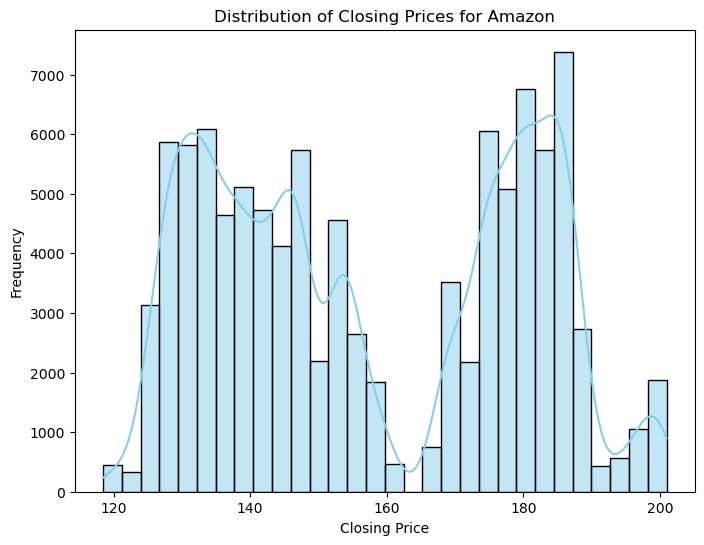

In [15]:
plt.figure(figsize=(8,6))
sns.histplot(df_new['close'],bins = 30,kde=True,color='skyblue',edgecolor='black')
plt.title('Distribution of Closing Prices for Amazon')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

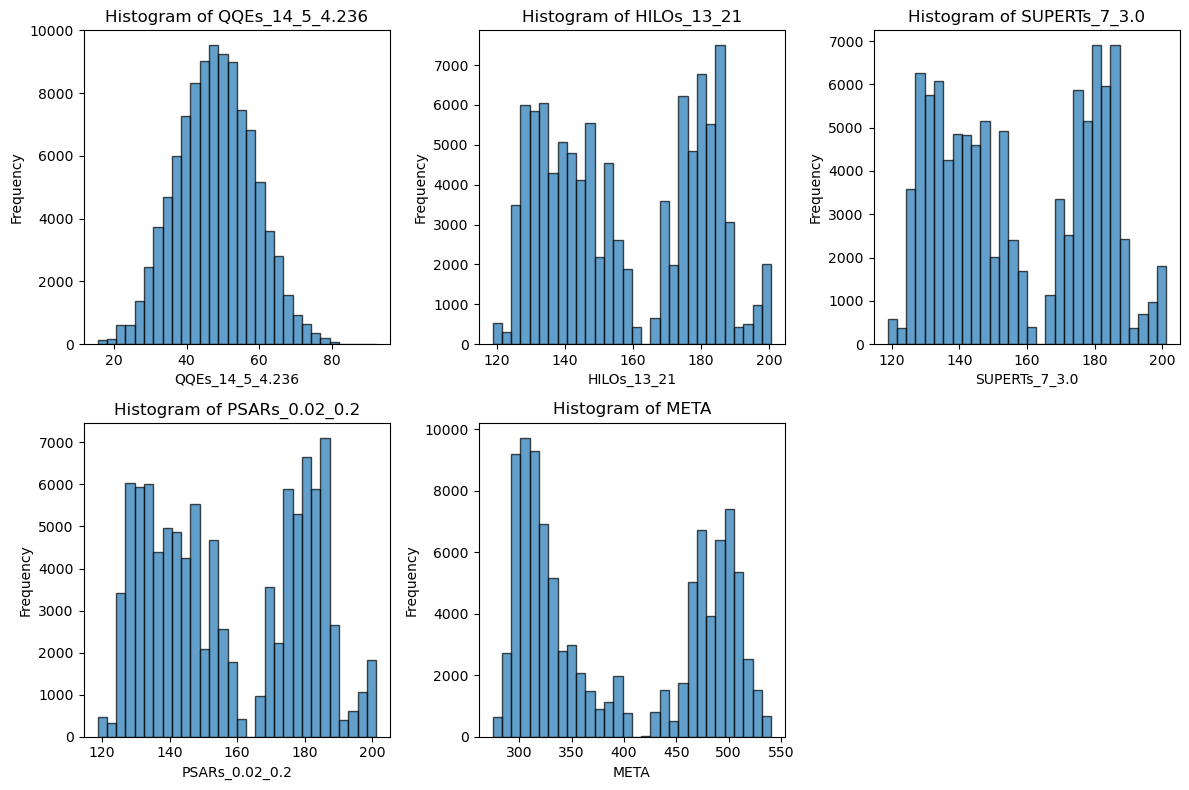

In [16]:
# Columns with nan values
columns_with_nan = ['QQEs_14_5_4.236', 'HILOs_13_21', 'SUPERTs_7_3.0', 'PSARs_0.02_0.2','META']

# Plot histograms for each column
plt.figure(figsize=(12, 8))

for i, col in enumerate(columns_with_nan, 1):
    plt.subplot(2, 3, i)
    plt.hist(df_new[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

----------------------------------------

##### Imputation Strategy for QQE Column:

Since the QQE column follows a normal distribution, we will impute missing values using the mean value of the column.

##### KS Test for Distribution Validation:

For the other 3 columns, we will perform a Kolmogorov-Smirnov (KS) test to validate that they follow the same distribution as the target close value of Amazon.


In [17]:
from scipy.stats import ks_2samp
# Filling QQE
QQE_mean = df_new['QQEs_14_5_4.236'].mean()
df_new['QQEs_14_5_4.236'].fillna(QQE_mean,inplace=True)

# Performing the KS test on the other variables
columns_to_test = [ 'HILOs_13_21', 'SUPERTs_7_3.0', 'PSARs_0.02_0.2','META']

for column in columns_to_test:
    target = df_new['close']
    test_col = column

    ks_statistic,p_value = ks_2samp(target,test_col)

    # Interpretation
    sig = 0.05
    if p_value < sig:
        print(f"The distributions are likely different (reject null hypothesis). KS statistic: {ks_statistic}, p-value: {p_value}")
    else:
        print(f"The distributions are likely similar (fail to reject null hypothesis). KS statistic: {ks_statistic}, p-value: {p_value}")


/var/folders/4r/7dgkc7nx5hs82x6_2yn0d3qc0000gn/T/ipykernel_30411/3010991831.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_new['QQEs_14_5_4.236'].fillna(QQE_mean,inplace=True)


The distributions are likely different (reject null hypothesis). KS statistic: 1.0, p-value: 0.0
The distributions are likely different (reject null hypothesis). KS statistic: 1.0, p-value: 0.0
The distributions are likely different (reject null hypothesis). KS statistic: 1.0, p-value: 0.0
The distributions are likely different (reject null hypothesis). KS statistic: 1.0, p-value: 0.0


-------------------
##### It doesn't seem like they follow the same distribution so, for simplicity we can impute using the median for these columns.

In [18]:
# Calculate medians for each column in columns_to_test
median_vals = df_new[columns_to_test].median()

# Impute missing values using medians
df_new[columns_to_test] = df_new[columns_to_test].fillna(median_vals)

df_new.isna().sum().sum()

0

-----------------------------
##### No missing values remaining

---------------------
### Handling and detecting outliers

Before eliminating the outliers in the data-set completely we are choosing to go with a windsorized approach to cap the oputliers on a percentile basis.

First though, we identify the outliers using a standard IQR approach. If noise is a big issue later we can use windsorization to fine tune the capping of the outliers and cap all the way at the upper and lower bounds of the IQR method if necessary.

In [19]:
# Function to detect outliers using IQR
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((data < lower_bound) | (data > upper_bound))

# Windsorization function
def apply_winsorization(data, lower_percentile=1, upper_percentile=99):
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    data_winsorized = np.where(data < lower_bound, lower_bound, np.where(data > upper_bound, upper_bound, data))
    return data_winsorized

# Applying IQR outlier detection to all numeric columns
outliers_iqr = {col: detect_outliers_iqr(df_new[col].dropna()) for col in df_new.select_dtypes(include=[np.number]).columns}

outliers_df = pd.DataFrame(outliers_iqr, index=['Outliers'])

htmldf(outliers_df)

,close,high,low,trade_count,open,volume,vwap,SMA_10,SMA_2,SMA_5,SMA_7,SMA_14,SMA_30,SMA_50,SMA_200,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ABER_ZG_5_15_A_BBL_20_2.0,ACCBL_20,ACCBM_20,ACCBU_20,AD,ADOSC_3_10,ADX_14,DMP_14,DMN_14,ALMA_10_6.0_0.85,AMATe_LR_8_21_2,AMATe_SR_8_21_2,AO_5_34,OBV,OBV_min_2,OBV_max_2,OBVe_4,OBVe_12,AOBV_LR_2,AOBV_SR_2,APO_12_26,AROOND_14,AROONU_14,AROONOSC_14,ATRr_14,ABER_ZG_5_15_B_BBL_20_2.0,BIAS_SMA_26,BOP,AR_26,BR_26,CCI_14_0.015,CFO_9,CG_10,CMO_14,COPC_11_14_10,CTI_12,ER_10,BULLP_13,BEARP_13,FISHERT_9_1,FISHERTs_9_1,INERTIA_20_14,K_9_3,D_9_3,J_9_3,KST_10_15_20_30_10_10_10_15,KSTs_9,MOM_10,PGO_14,PPO_12_26_9,PPOh_12_26_9,PPOs_12_26_9,PSL_12,PVO_12_26_9,PVOh_12_26_9,PVOs_12_26_9,QQE_14_5_4.236,QQE_14_5_4.236_RSIMA,QQEl_14_5_4.236,QQEs_14_5_4.236,ROC_10,RSX_14,RVGI_14_4,RVGIs_14_4,SLOPE_1,SMI_5_20_5,SMIs_5_20_5,SMIo_5_20_5,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO,SQZPRO_20_2.0_20_2_1.5_1,SQZPRO_ON_WIDE,SQZPRO_ON_NORMAL,SQZPRO_ON_NARROW,SQZPRO_OFF,SQZPRO_NO,STC_10_12_26_0.5,STCmacd_10_12_26_0.5,STCstoch_10_12_26_0.5,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UO_7_14_28,WILLR_14,DEMA_10,EMA_10,FWMA_10,HILO_13_21,HILOl_13_21,HILOs_13_21,HL2,HLC3,HMA_10,HWMA_0.2_0.1_0.1,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,JMA_7_0,KAMA_10_2_30,LR_14,MIDPOINT_2,OHLC4,PWMA_10,SINWMA_14,SSF_10_2,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0,T3_10_0.7,TEMA_10,TRIMA_10,VIDYA_14,VWAP_D,VWMA_10,WCP,ZL_EMA_10,LOGRET_1,PCTRET_1,ENTP_10,KURT_30,MAD_30,MEDIAN_30,QTL_30_0.5,SKEW_30,STDEV_30,TOS_STDEVALL_LR,TOS_STDEVALL_L_1,TOS_STDEVALL_U_1,TOS_STDEVALL_L_2,TOS_STDEVALL_U_2,TOS_STDEVALL_L_3,TOS_STDEVALL_U_3,VAR_30,ZS_30,CHOP_14_1_100,CKSPl_10_3_20,CKSPs_10_3_20,LDECAY_5,DEC_1,DPO_20,INC_1,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,QS_10,TTM_TRND_6,VHF_28,VTXP_14,VTXM_14,DCL_20_20,DCM_20_20,DCU_20_20,HWM,HWU,HWL,KCLe_20_2,KCBe_20_2,KCUe_20_2,MASSI_9_25,NATR_14,PDIST,RVI_14,THERMO_20_2_0.5,THERMOma_20_2_0.5,THERMOl_20_2_0.5,THERMOs_20_2_0.5,TRUERANGE_1,UI_14,Revenue,Net_Income,Gross_Profit,Total_Debt,Operating_Cash_Flow,AAPL,MSFT,GOOGL,META,WMT,BABA
Outliers,[],[],[],"[0, 1, 2, 3, 6, 10, 11, 14, 17, 18, 19, 21, 25, 26, 28, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 259, 380, 382, 385, 386, 387, 388, 389, 390, 392, 393, 429, 430, 431, 459, 460, 475, 480, 768, 769, 777, 780, 781, 785, 786, 787, 788, 789, 790, 791, 792, 799, 800, 803, 805, 807, 844, 855, 874, 890, 1126, 1127, 1128, 1161, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1180, 1199, 1229, 1239, 1536, 1543, 1556, 1558, 1560, 1561, 1562, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, ...]",[],"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 20, 21, 22, 25, 26, 28, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 73, 74, 77, 106, 231, 259, 300, 380, 382, 385, 386, 387, 388, 389, 390, 392, 393, 395, 399, 407, 408, 409, 411, 414, 417, 421, 423, 428, 429, 430, 449, 450, 452, 459, 460, 461, 480, 497, 542, 565, 566, 637, 687, 691, 765, 767, 768, 769, 772, 774, 775, 776, 777, 780, 781, 785, 786, 787, 788, 789, 790, 791, 792, 793, 796, 797, 799, 800, ...]",[],[],[],[],[],[],[],[],[],[],[],[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 528, 529, 530, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1271, 1272, 1273, 1274, ...]","[6332, 7114, 16577, 20521, 22483, 24829, 25223, 27949, 37131, 38308, 40480, 41262, 41653, 42828, 43613, 49874, 53030, 56946, 60938, 63295, 65258, 67215, 68372, 72283, 80918, 81315, 81316, 81317, 81318, 81738, 83780, 86460, 88416, 92330, 100333

**Outlier Observation:**

There are numerous outliers present in the rows for the feature columns, although the target 'close' column appears to have negligible outliers.

**Model Fine-Tuning Consideration:**

As we proceed with fine-tuning the model and approach, it may become necessary to address outliers in these feature columns based on their impact on the overall model.

**Approach:**

Windsorization appears to be a suitable starting point for addressing outliers in these features.


----------------------------------
### Looking at how well each moving average handles noise.

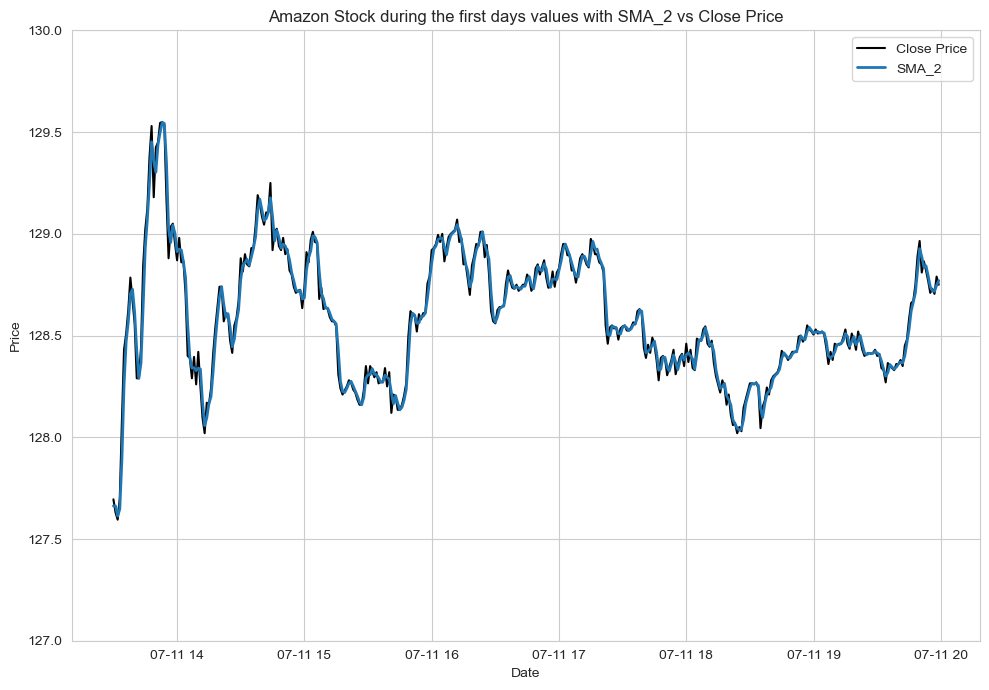

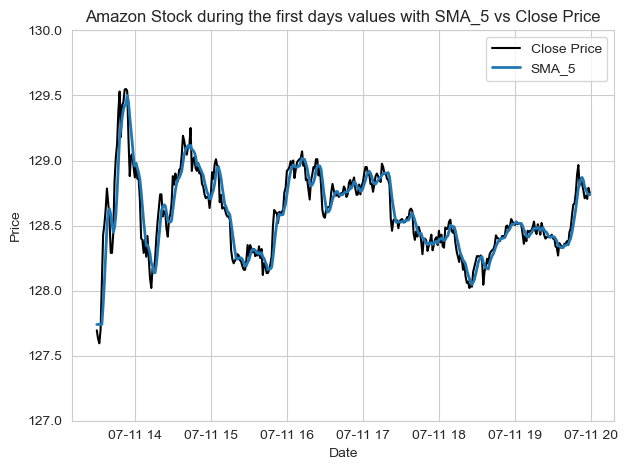

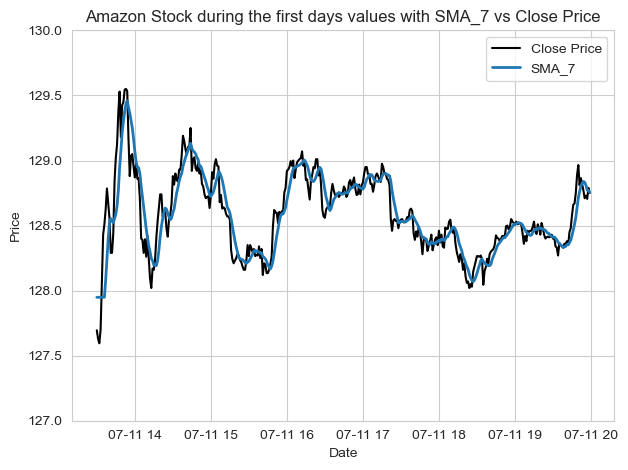

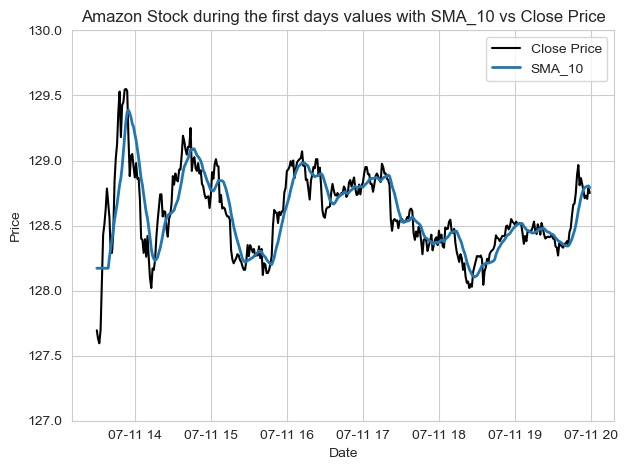

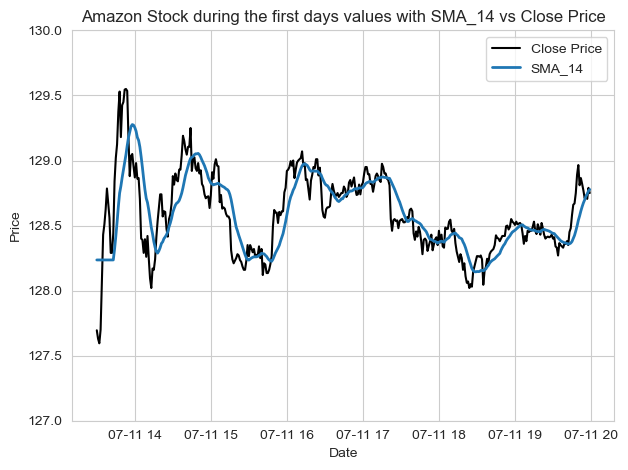

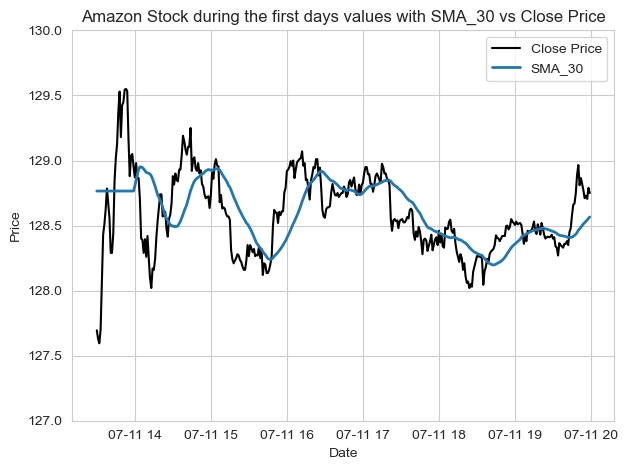

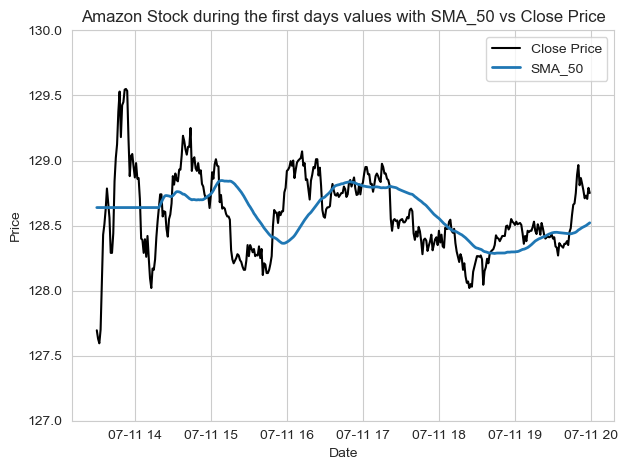

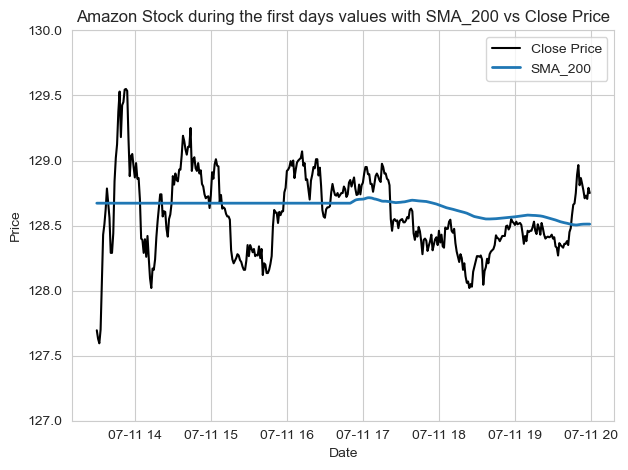

In [21]:
# Define the date range
start = '2023-07-11 13:30:00+00:00'
end = '2023-07-11 19:59:00+00:00'

subset_df = df_new[start:end]

# List of moving averages to plot
moving_averages = ['SMA_2', 'SMA_5', 'SMA_7', 'SMA_10', 'SMA_14', 'SMA_30', 'SMA_50', 'SMA_200']

# Set seaborn style
sns.set_style('whitegrid')

# Plotting each moving average against the close price
plt.figure(figsize=(10, 7))

for ma in moving_averages:
    plt.plot(subset_df.index, subset_df['close'], label='Close Price', color='black')
    plt.plot(subset_df.index, subset_df[ma], label=f'{ma}', linewidth=2)

    plt.title(f'Amazon Stock during the first days values with {ma} vs Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.ylim(127, 130)  # Set y-axis limits
    plt.legend()
    plt.tight_layout()
    plt.show()

#### It seems like the SMA-2 holds the best to the closing price but it may be overly biased and sensistive to quick changes. It also looks like it holds close to some of the noise as well. 
#### SMA-7 looks like a smoother approach while following the general trend of the series. This could be the column used to plot points and base peak and valley indicator columns on.
#### Going forward this SMA-7 line will be used for all the data to help filter out noise.

-----------------------
### Duplicate values check and removal

In [23]:
# Check for duplicate rows
duplicate_rows = df_new[df_new.duplicated()]
print("Duplicate rows:\n", duplicate_rows)

# Optionally, drop duplicate rows
df_new = df_new.drop_duplicates()

Duplicate rows:
                              close     high      low  trade_count     open  \
timestamp                                                                    
2023-07-26 20:29:00+00:00  128.760  128.760  128.760          1.0  128.760   
2023-07-26 20:35:00+00:00  128.760  128.760  128.760          1.0  128.760   
2023-07-28 12:02:00+00:00  128.265  128.400  128.235        203.0  128.290   
2023-07-28 12:03:00+00:00  128.265  128.400  128.235        203.0  128.290   
2023-07-28 12:04:00+00:00  128.265  128.400  128.235        203.0  128.290   
2023-07-28 12:06:00+00:00  128.265  128.400  128.235        203.0  128.290   
2023-07-28 12:07:00+00:00  128.265  128.400  128.235        203.0  128.290   
2023-07-28 12:08:00+00:00  128.265  128.400  128.235        203.0  128.290   
2023-07-28 12:18:00+00:00  128.265  128.400  128.235        203.0  128.290   
2023-08-23 20:26:00+00:00  135.490  135.510  135.405        257.0  135.410   
2023-08-25 13:25:00+00:00  131.840  132.175  13

-------------------------
## Correlation Check

In [24]:
correlation_df = df_new.corr()
htmldf(correlation_df)

,close,high,low,trade_count,open,volume,vwap,SMA_10,SMA_2,SMA_5,SMA_7,SMA_14,SMA_30,SMA_50,SMA_200,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ABER_ZG_5_15_A_BBL_20_2.0,ACCBL_20,ACCBM_20,ACCBU_20,AD,ADOSC_3_10,ADX_14,DMP_14,DMN_14,ALMA_10_6.0_0.85,AMATe_LR_8_21_2,AMATe_SR_8_21_2,AO_5_34,OBV,OBV_min_2,OBV_max_2,OBVe_4,OBVe_12,AOBV_LR_2,AOBV_SR_2,APO_12_26,AROOND_14,AROONU_14,AROONOSC_14,ATRr_14,ABER_ZG_5_15_B_BBL_20_2.0,BIAS_SMA_26,BOP,AR_26,BR_26,CCI_14_0.015,CFO_9,CG_10,CMO_14,COPC_11_14_10,CTI_12,ER_10,BULLP_13,BEARP_13,FISHERT_9_1,FISHERTs_9_1,INERTIA_20_14,K_9_3,D_9_3,J_9_3,KST_10_15_20_30_10_10_10_15,KSTs_9,MOM_10,PGO_14,PPO_12_26_9,PPOh_12_26_9,PPOs_12_26_9,PSL_12,PVO_12_26_9,PVOh_12_26_9,PVOs_12_26_9,QQE_14_5_4.236,QQE_14_5_4.236_RSIMA,QQEl_14_5_4.236,QQEs_14_5_4.236,ROC_10,RSX_14,RVGI_14_4,RVGIs_14_4,SLOPE_1,SMI_5_20_5,SMIs_5_20_5,SMIo_5_20_5,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO,SQZPRO_20_2.0_20_2_1.5_1,SQZPRO_ON_WIDE,SQZPRO_ON_NORMAL,SQZPRO_ON_NARROW,SQZPRO_OFF,SQZPRO_NO,STC_10_12_26_0.5,STCmacd_10_12_26_0.5,STCstoch_10_12_26_0.5,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UO_7_14_28,WILLR_14,DEMA_10,EMA_10,FWMA_10,HILO_13_21,HILOl_13_21,HILOs_13_21,HL2,HLC3,HMA_10,HWMA_0.2_0.1_0.1,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,JMA_7_0,KAMA_10_2_30,LR_14,MIDPOINT_2,OHLC4,PWMA_10,SINWMA_14,SSF_10_2,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0,T3_10_0.7,TEMA_10,TRIMA_10,VIDYA_14,VWAP_D,VWMA_10,WCP,ZL_EMA_10,LOGRET_1,PCTRET_1,ENTP_10,KURT_30,MAD_30,MEDIAN_30,QTL_30_0.5,SKEW_30,STDEV_30,TOS_STDEVALL_LR,TOS_STDEVALL_L_1,TOS_STDEVALL_U_1,TOS_STDEVALL_L_2,TOS_STDEVALL_U_2,TOS_STDEVALL_L_3,TOS_STDEVALL_U_3,VAR_30,ZS_30,CHOP_14_1_100,CKSPl_10_3_20,CKSPs_10_3_20,LDECAY_5,DEC_1,DPO_20,INC_1,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,QS_10,TTM_TRND_6,VHF_28,VTXP_14,VTXM_14,DCL_20_20,DCM_20_20,DCU_20_20,HWM,HWU,HWL,KCLe_20_2,KCBe_20_2,KCUe_20_2,MASSI_9_25,NATR_14,PDIST,RVI_14,THERMO_20_2_0.5,THERMOma_20_2_0.5,THERMOl_20_2_0.5,THERMOs_20_2_0.5,TRUERANGE_1,UI_14,Revenue,Net_Income,Gross_Profit,Total_Debt,Operating_Cash_Flow,AAPL,MSFT,GOOGL,META,WMT,BABA
close,1.000000,0.999994,0.999994,-0.112248,0.999989,-0.113178,0.999997,0.999932,0.999994,0.999969,0.999954,0.999907,0.999811,0.999692,0.998796,0.999691,0.999871,0.999765,-0.096172,0.010171,0.019774,0.029571,0.007358,0.029115,0.999966,0.999963,0.999959,0.028365,0.017932,0.999832,0.999871,0.999842,0.975464,0.015066,0.005421,0.136491,0.116805,0.998231,0.007510,-0.006945,0.025258,0.959546,0.959554,0.959540,0.959549,0.959552,-0.003421,0.003760,0.020883,-0.017451,0.006693,0.013688,0.027948,NaN,0.019242,0.000096,0.016336,0.028780,0.007965,0.001392,0.013360,0.019774,0.016464,0.009061,0.023253,0.015720,0.022952,0.015432,0.015735,-0.003738,0.014922,0.017879,0.008894,0.022433,0.022048,0.017500,0.011799,0.017210,0.004744,0.018150,0.004900,-0.012625,-0.003625,-0.013031,0.020423,0.022124,0.025526,0.004917,0.013969,0.015960,-0.004921,-0.004750,0.001026,0.019742,0.021292,0.000468,0.019124,-0.021833,0.023015,-0.018376,0.019124,-0.058869,-0.021833,-0.009392,0.059486,-0.018376,0.019450,0.028858,0.019479,0.007684,0.008892,0.033445,0.033649,0.025058,0.027029,0.015679,0.013485,0.999979,0.999953,0.999985,0.999852,0.999724,0.999718,0.999997,0.999999,0.999977,0.999921,0.999450,0.999276,0.999951,0.999872,0.999495,0.999988,0.997722,0.999967,0.999994,0.999997,0.999911,0.999895,0.999936,0.999708,0.012024,0.999615,0.999386,0.999902,0.999988,0.999922,0.996556,0.999207,0.999925,0.999999,0.999986,-0.000377,-0.000473,0.015823,-0.000456,0.034389,0.999770,0.999770,-0.016422,0.037463,0.945066,0.945066,0.945066,0.945066,0.945066,0.945066,0.945066,0.003598,0.009449,-0.088582,0.999810,0.999760,0.999995,0.002052,0.018543,-0.000463,0.999777,0.998991,-0.009363,-0.003380,0.005300,0.007247,0.031466,-0.023485,-0.026832,0.999779,0.999901,0.999823,0.999921,0.99

**Correlation Analysis:**

Looking at the data above, it is evident that many variables are highly correlated with the target column (close).

**Dimensionality Reduction:**

To reduce the dimensionality of the current variables and determine which of them explain more of the variance, it may be wise to perform Principal Component Analysis (PCA).

**Further Insight:**

PCA might also provide further insight into some combinations of variables that we could use to better capture variance.

In [ ]:
#### PCA plotting for visual

Number of components to retain 90.0% variance: 22
Number of components to retain 95.0% variance: 34
Number of components to retain 99.0% variance: 60


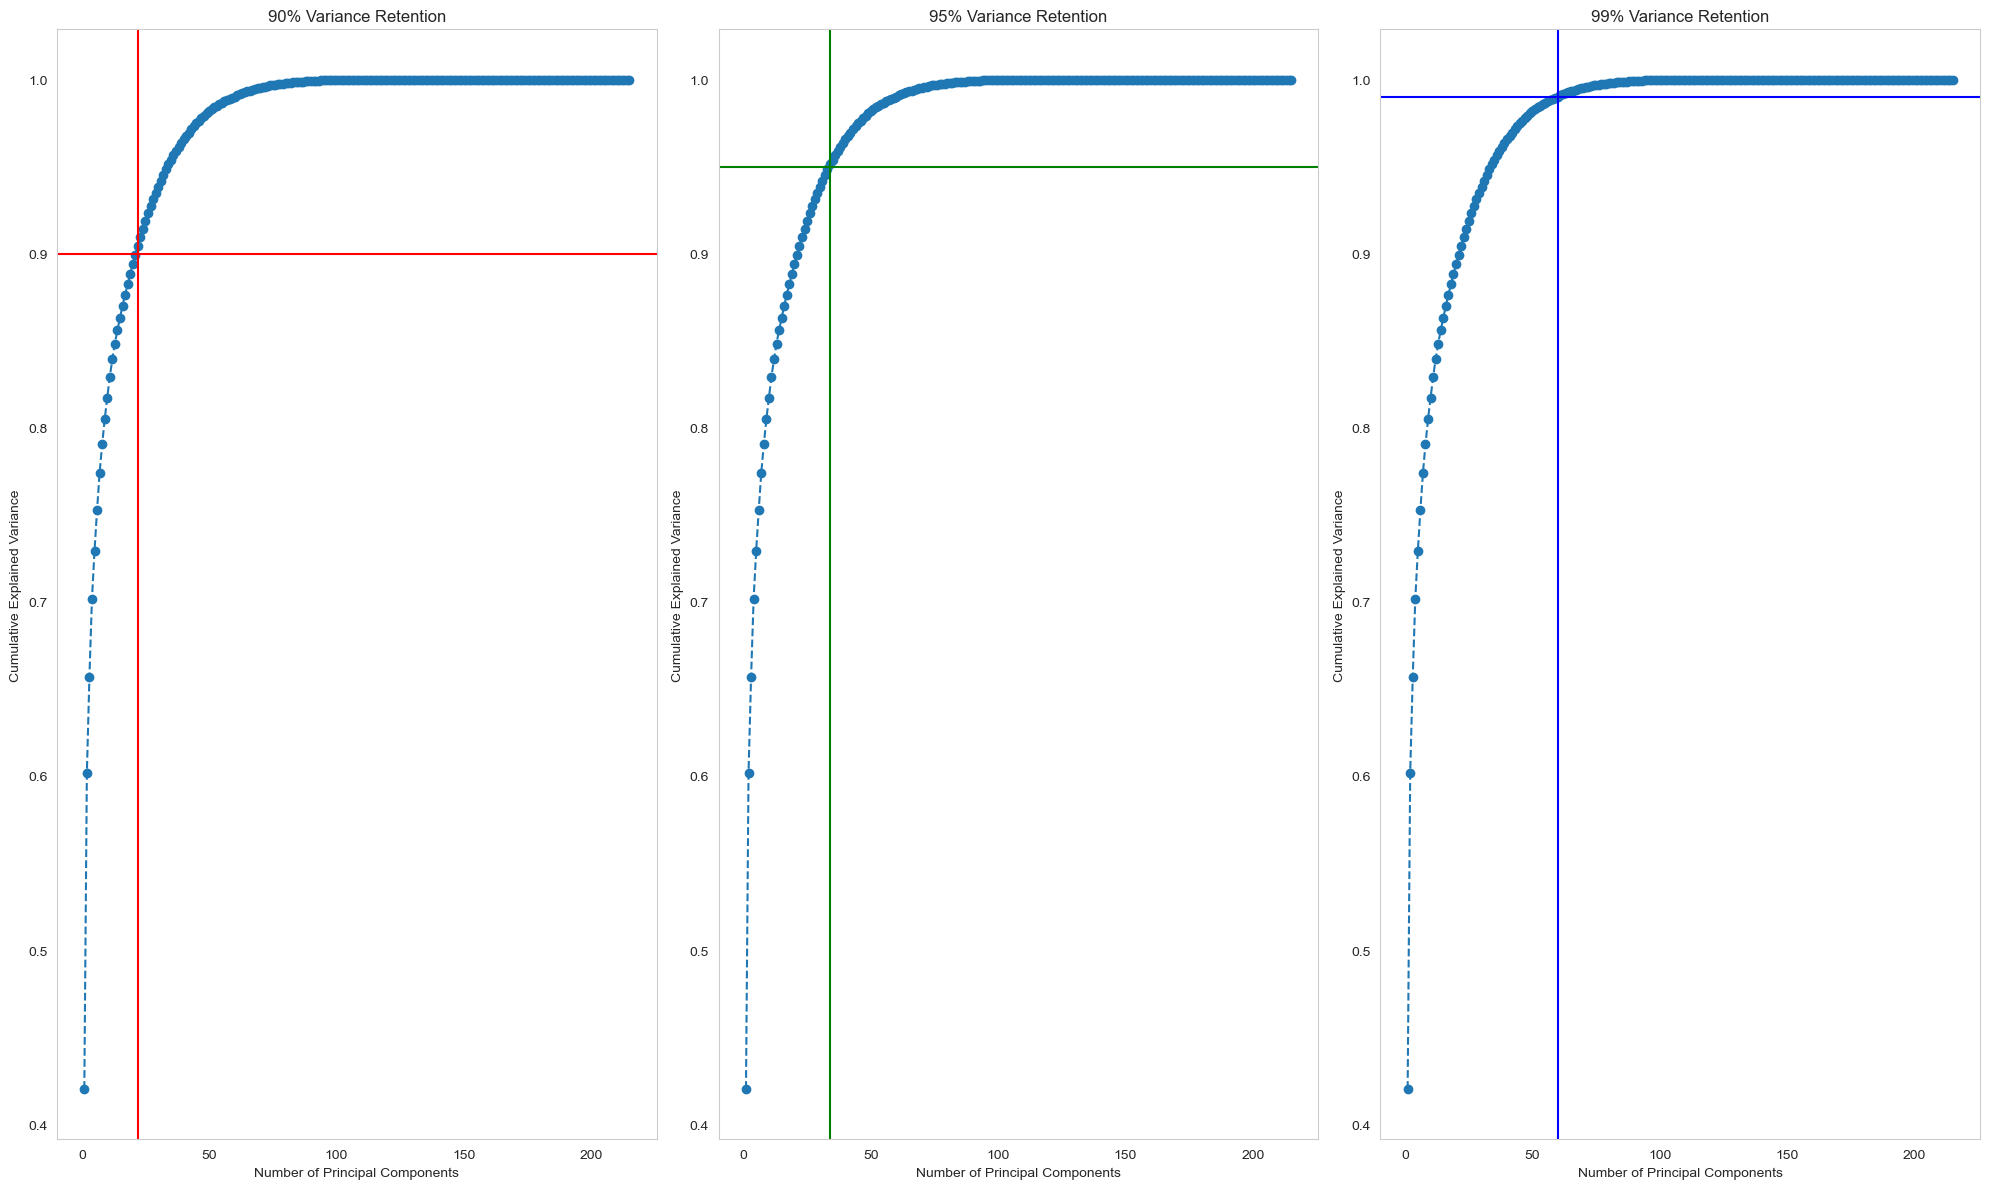

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = df_new.drop(columns=['close'])
target = df_new['close']

scaler = StandardScaler()
standardized_features = scaler.fit_transform(features)

pca = PCA()
pca.fit(standardized_features)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


thresholds = [0.90, 0.95, 0.99]
num_components = [np.argmax(cumulative_variance >= threshold) + 1 for threshold in thresholds]

for threshold, num in zip(thresholds, num_components):
    print(f'Number of components to retain {threshold * 100}% variance: {num}')

plt.figure(figsize=(20, 12))

# Plot for 90% variance retention
plt.subplot(1, 3, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.axvline(x=num_components[0], color='r', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('90% Variance Retention')
plt.grid()

# Plot for 95% variance retention
plt.subplot(1, 3, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='g', linestyle='-')
plt.axvline(x=num_components[1], color='g', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('95% Variance Retention')
plt.grid()

# Plot for 99% variance retention
plt.subplot(1, 3, 3)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.99, color='b', linestyle='-')
plt.axvline(x=num_components[2], color='b', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('99% Variance Retention')
plt.grid()

plt.tight_layout()
plt.show()



---------------------
As we can see in the plots above:

        -- when 10% of the variance is traded off, we will be left with only 20 features.
        -- when 5% of the variance is traded off, we will be left with only 34 features.
        -- when 1% of the variance is traded off, we will be left with only 60 features.

Now to check what these components are and see what the overlap is.